#### Upload dataset from google drive

In [44]:
!pip install gdown
!pip install tensorflow

In [45]:
import os
import gdown
import zipfile
import pydot
from pathlib import Path

from pathlib import Path
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

In [46]:
# Downloading Dataset and extracting data points
file_id = "1unDpBmcZidHfTgKyqaMnh6EMcdVeBvzw"
output = "dataset.zip"

data_dir = Path("data")
if data_dir.exists() and any(data_dir.iterdir()):
    print("data directory already exists and contains files — skipping download/extract.")
else:
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall("data")

    os.remove(output)

data directory already exists and contains files — skipping download/extract.


#### Load dataset from folders into numpy arrays

In [47]:
def load_dataset(data_dir, image_size=(128, 128)):
    data_dir = Path(data_dir)
    images = []
    labels = []

    classes = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
    for label_index, class_name in enumerate(classes):
        class_dir = data_dir / class_name
        for img_path in class_dir.iterdir():
            if img_path.suffix.lower() in [".jpg", ".png", ".jpeg"]:
                img = Image.open(img_path).convert("RGB")
                img = img.resize(image_size)
                images.append(np.array(img) / 255.0)  # normalize to [0,1]
                labels.append(label_index)

    return np.array(images), np.array(labels), classes

# Training/Test Split
X_train, y_train, classes = load_dataset("data/training/training")
X_test, y_test, _ = load_dataset("data/validation/validation")

print("Training images:", X_train.shape)
print("Training labels:", y_train.shape)
print("Test images:", X_test.shape)
print("Test labels:", y_test.shape)

Training images: (1097, 128, 128, 3)
Training labels: (1097,)
Test images: (272, 128, 128, 3)
Test labels: (272,)


#### Convert numpy arrays into _TensorSliceDataset, make the test dataset from the validation set

In [48]:
training_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# make test dataset from validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 218
Number of test batches: 54


#### Plot some training data points

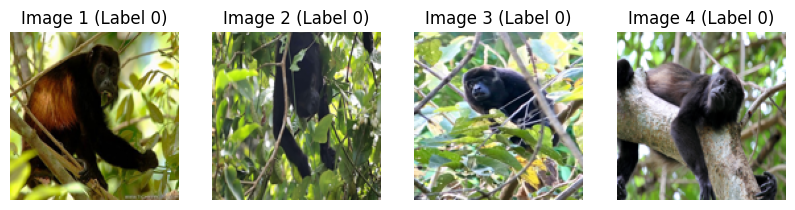

In [49]:
plt.figure(figsize=(10, 5))

for i, (image, label) in enumerate(training_dataset.take(4)):  
    image_numpy = image.numpy()  # convert image tensor → numpy

    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(image_numpy)
    plt.title(f"Image {i+1} (Label {label.numpy()})")
    plt.axis("off")

plt.show()

#### Configure datasets (shuffle, batch, prefetch)

In [50]:
training_dataset = training_dataset.shuffle(buffer_size=len(X_train))
training_dataset = training_dataset.batch(batch_size=32)

validation_dataset = validation_dataset.shuffle(buffer_size=len(X_train))
validation_dataset = validation_dataset.batch(batch_size=32)

training_dataset = training_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

#### Data Augmentation

In [51]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.3),
])

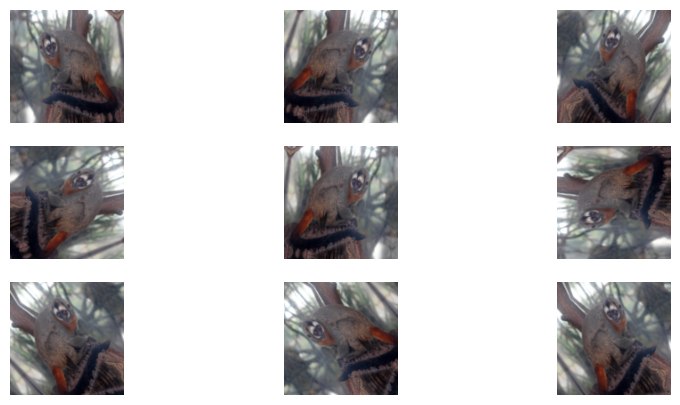

In [52]:
plt.figure(figsize=(10, 5))

for images, labels in training_dataset.take(1):  
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
        plt.axis('off')

plt.show()

#### Rescale pixel values to fit MobileNetV2

In [53]:
# The following code is brought over from rescaling the input and applying a hidden layer
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

#### Create base model MobileNet V2 (before hyperparameter tuning)

In [54]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), # Represents dataset image dimensions of 128x128 pixels and with 3 color channels
                                               alpha=1.0,
                                               include_top=False,
                                               weights='imagenet')

In [55]:
image_batch, label_batch = next(iter(training_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# Freezing
base_model.trainable = False

(32, 4, 4, 1280)


In [56]:
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [57]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [58]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [59]:
inputs = tf.keras.Input(shape=(128, 128, 3))

x = rescale(inputs)
# x = preprocess_input(inputs)

x = data_augmentation(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(classes), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Above, our model is equipped with 12,810 trainable parameters. This is due to the fact our dataset has 10 classifications, and subsequently about 10 times the trainable params as are found in the CNN discussed in class.

In [60]:
len(model.trainable_variables)

2

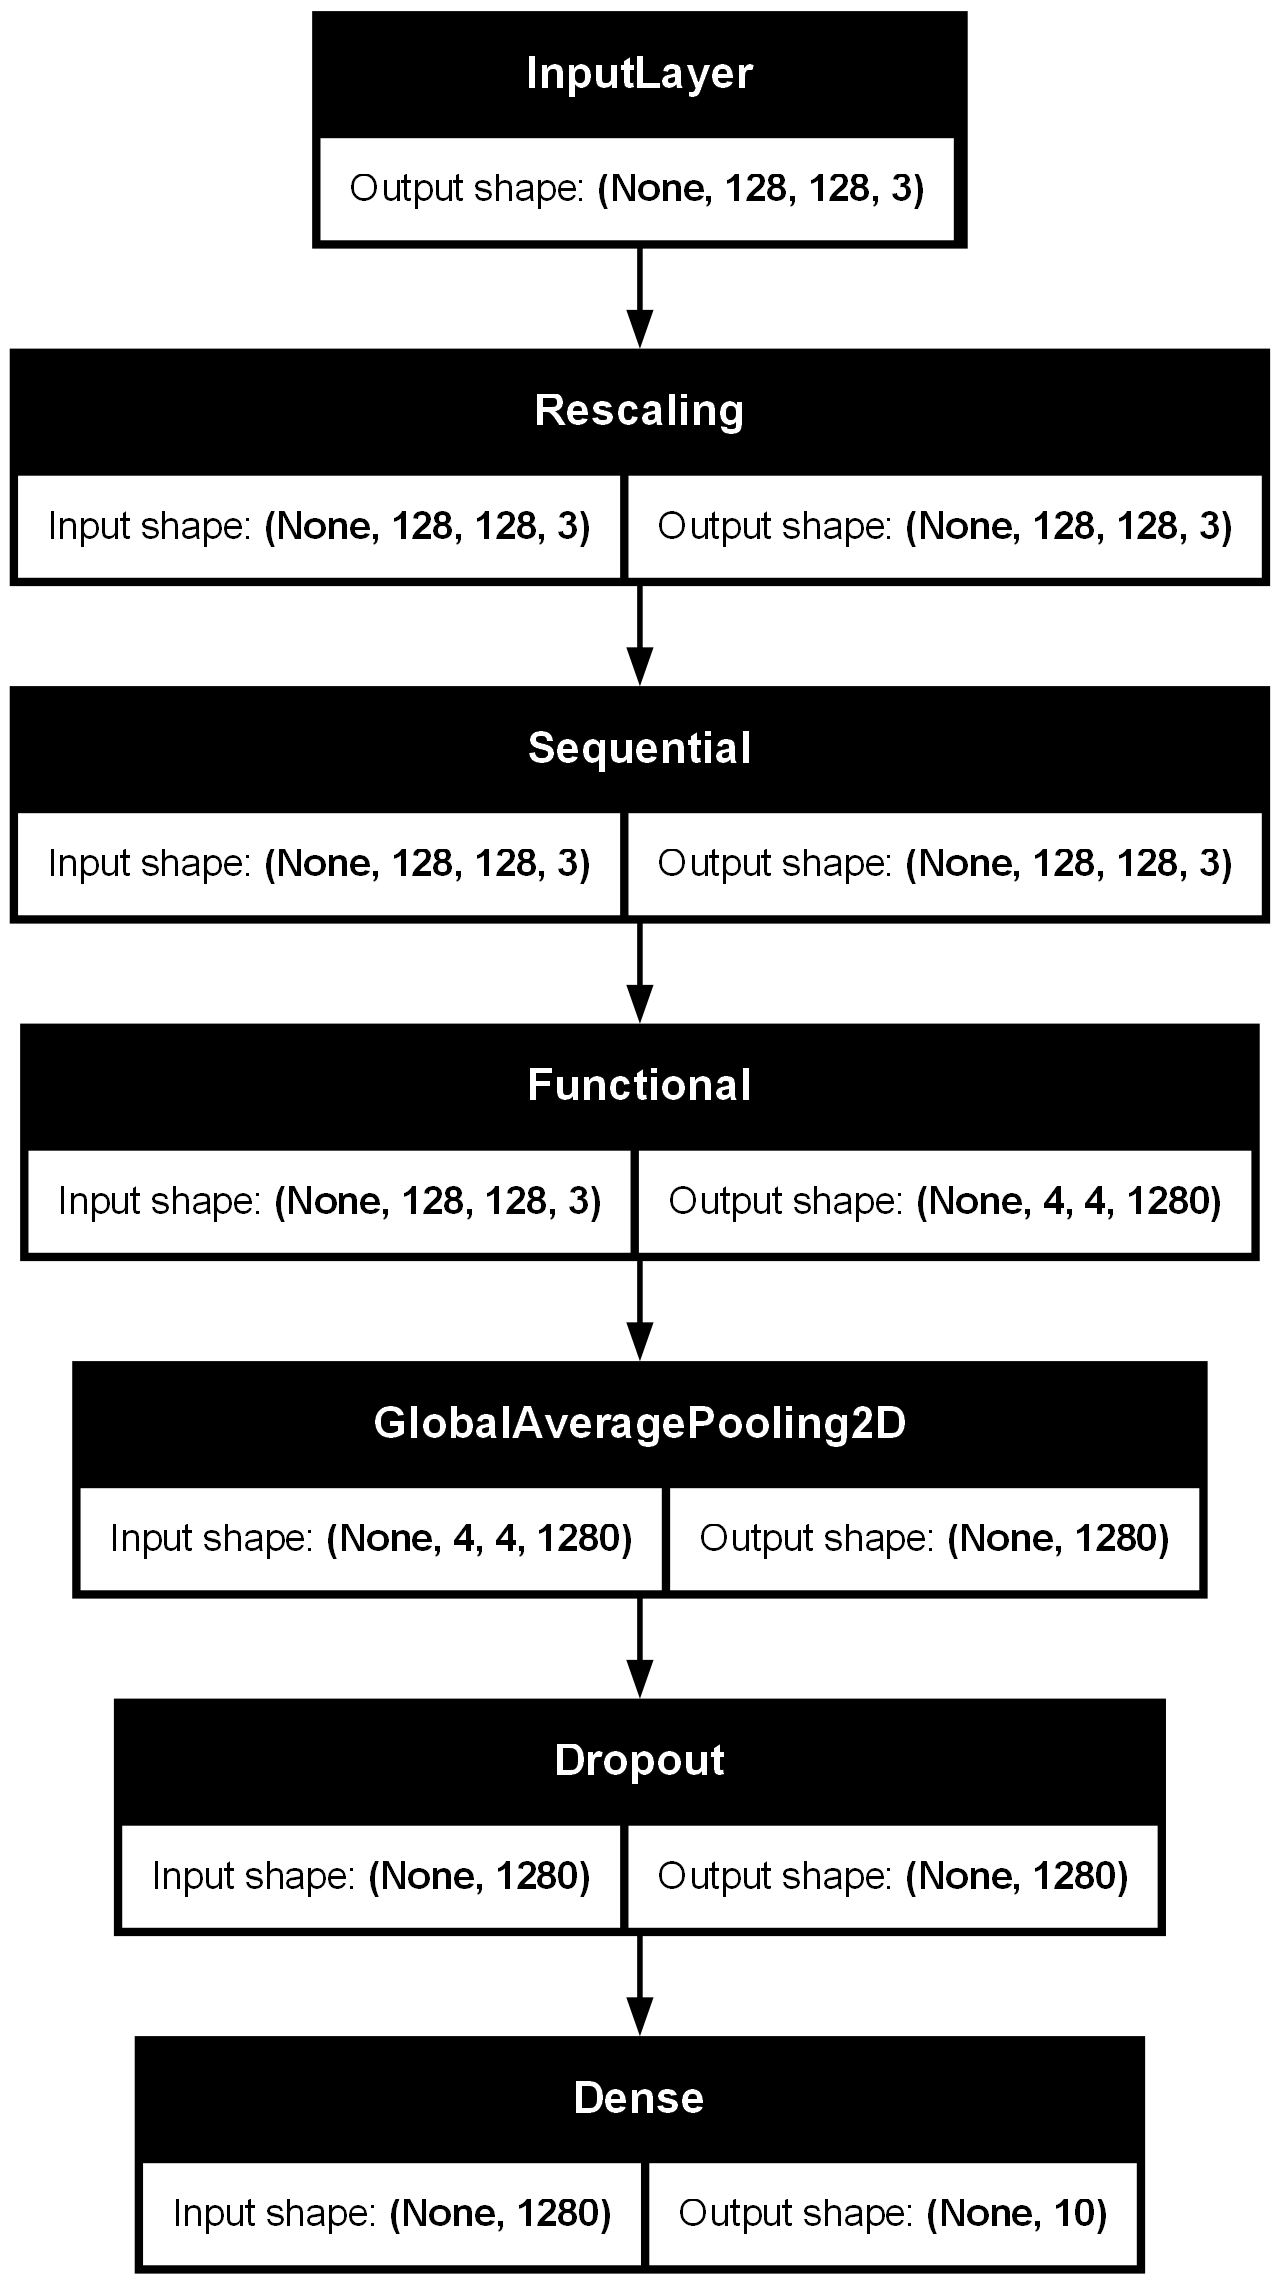

In [61]:
tf.keras.utils.plot_model(model, show_shapes=True)

#### Model Compilation

In [62]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
            #   loss=tf.keras.losses.BinaryCrossentropy(),
            #   metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [63]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.0000e+00 - loss: 2.7317


In [64]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.73
initial accuracy: 0.00


In [65]:
history = model.fit(training_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.0957 - loss: 2.5971 - val_accuracy: 0.0138 - val_loss: 2.3859
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.0857 - loss: 2.4529 - val_accuracy: 0.1376 - val_loss: 2.3072
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.1057 - loss: 2.4037 - val_accuracy: 0.1422 - val_loss: 2.2950
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.0966 - loss: 2.4206 - val_accuracy: 0.1697 - val_loss: 2.2913
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.0966 - loss: 2.4530 - val_accuracy: 0.1468 - val_loss: 2.2940
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.1139 - loss: 2.3907 - val_accuracy: 0.1514 - val_loss: 2.2908
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.0839 - loss: 2.4234 - val_accuracy: 0.1468 - val_loss: 2.2851
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.1103 - loss: 2.3888 - val_accuracy: 0.197

## Model Analysis: Learning Curve

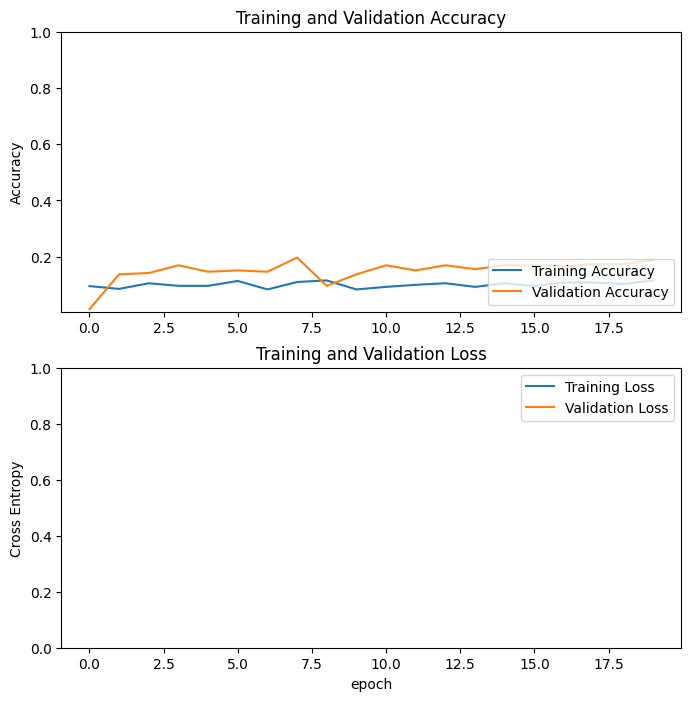

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()